In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/home/eplinux/ikas_case_study/advanced_user_events_with_uuid.csv")

# Convert 'timestamp' to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define 'today' as the latest timestamp in the dataset
today = df['timestamp'].max() + pd.Timedelta(days=1)

df_filtered = df[df["event_type"].isin(["payment_success", "checkout_start"])]

# Recency: Days since the user's last activity
df_recency = df_filtered.groupby('user_id')['timestamp'].max().reset_index()
df_recency['recency'] = (today - df_recency['timestamp']).dt.days

# Frequency: Count of 'payment_success' events per user
df_payment_success = df[df['event_type'] == 'payment_success']
df_frequency = df_payment_success.groupby('user_id').size().reset_index(name='frequency')

# Combine Recency and Frequency into one DataFrame
rf = df_recency[['user_id', 'recency']].merge(df_frequency, on='user_id', how='left')

# Fill missing frequency values with 0 (for users with no purchases)
rf['frequency'] = rf['frequency'].fillna(0)

# Assign scores from 1 (worst) to 5 (best)
rf['recency_score'] = pd.qcut(rf['recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rf['frequency_score'] = pd.qcut(rf['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine RF scores into a single string
rf['RF_score'] = rf['recency_score'].astype(str) + rf['frequency_score'].astype(str)

# Define customer segments based on Recency and Frequency scores
def segment_rf_only(row):
    r = row['recency_score']
    f = row['frequency_score']

    # Spesifikten genele doğru koşulları kontrol edelim
    if r == 5 and f in [4, 5]:
        return 'champions'
    elif r == 5 and f == 1:
        return 'new_customers'
    elif r in [4, 5] and f in [2, 3]:
        return 'potential_loyalists'
    elif r == 4 and f == 1:
        return 'promising'
    elif r in [3, 4] and f in [4, 5]:
        return 'loyal_customers'
    elif r == 3 and f == 3:
        return 'need_attention'
    elif r == 3 and f in [1, 2]:
        return 'about_to_sleep'
    elif r in [1, 2] and f == 5:
        return 'cant_loose'
    elif r in [1, 2] and f in [3, 4]:
        return 'at_risk'
    elif r in [1, 2] and f in [1, 2]:
        return 'hibernating'
    else:
        return 'other'

rf['segment'] = rf.apply(segment_rf_only, axis=1)



/tmp/ipykernel_68758/945684011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rf, x='segment', order=segment_order, palette=colors)


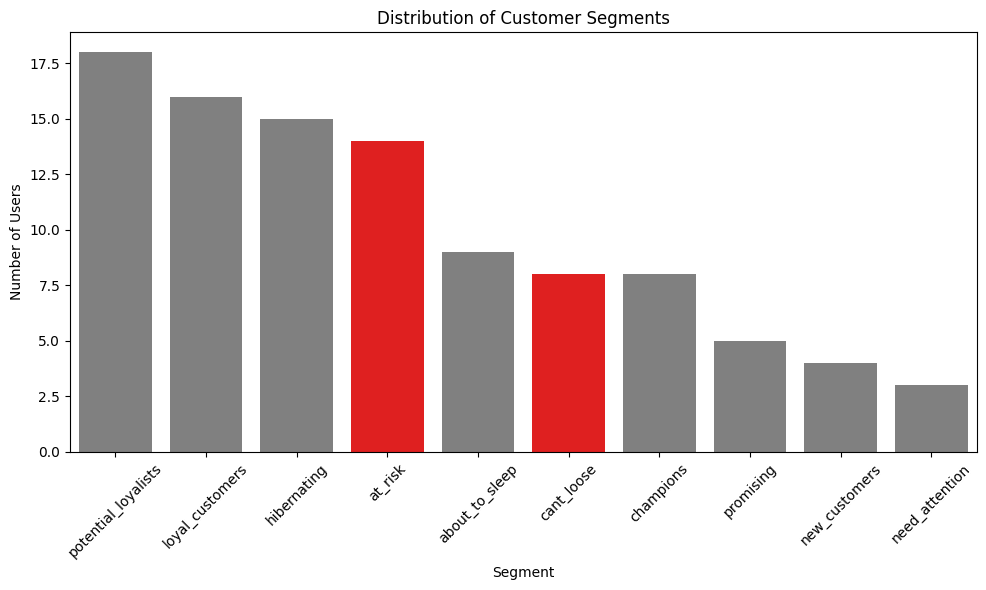

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get segment counts in order
segment_order = rf['segment'].value_counts().index

# Define custom color palette
colors = []
for segment in segment_order:
    if segment in ['cant_loose', 'at_risk']:
        colors.append('red')
    else:
        colors.append('gray')  # default color for other segments

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.countplot(data=rf, x='segment', order=segment_order, palette=colors)
plt.title('Distribution of Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
rf_cleaned = rf[["user_id", "segment"]]  
rf_cleaned.to_csv("/home/eplinux/ikas_case_study/new_feature_datas/PAY_rf_segmented_users.csv", index=False)